In [31]:
# Data libs
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa

# ML libs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Plotting libs
import matplotlib.pyplot as plt

In [32]:
#
# Read data from parquet files
# Generated by:
# .pcap -> .csv (CICFlowMeter)
# .csv -> .parquet (pyarrow, scripts/csv_to_parquet.py)
#

dns_flows = pd.read_parquet("../data/parquet/DNS.parquet")
print(f"Read DNS: {dns_flows.shape}")

ldap_flows = pd.read_parquet("../data/parquet/LDAP.parquet")
print(f"Read LDAP: {ldap_flows.shape}")

ntp_flows = pd.read_parquet("../data/parquet/NTP.parquet")
print(f"Read NTP: {ntp_flows.shape}")

snmp_flows = pd.read_parquet("../data/parquet/SNMP.parquet")
print(f"Read SNMP: {snmp_flows.shape}")

ssdp_flows = pd.read_parquet("../data/parquet/SSDP.parquet")
print(f"Read SSDP: {ssdp_flows.shape}")

udp_lag_flows = pd.read_parquet("../data/parquet/UDP-lag.parquet")
print(f"Read UDP-lag: {udp_lag_flows.shape}")

udp_flows = pd.read_parquet("../data/parquet/UDP.parquet")
print(f"Read UDP: {udp_flows.shape}")

Read DNS: (114, 82)
Read LDAP: (209, 82)
Read NTP: (970, 82)
Read SNMP: (37, 82)
Read SSDP: (940, 82)
Read UDP-lag: (984, 82)
Read UDP: (950, 82)


In [33]:
#
# There is more benign data than can be reasonable loaded. Also, using all of it
# would heavily imbalance and skew ML. So instead, we will sample 1000 rows from
# the benign data.
#
# We can do this easily using the block structure of parquet files.
#

sample_rows = 1000

pf = pq.ParquetFile("../data/parquet/benign.parquet")

num_row_groups = pf.num_row_groups
rows_per_rg = pf.metadata.row_group(0).num_rows

num_rgs_to_read = max(1, sample_rows // rows_per_rg)

rng = np.random.default_rng()
chosen_rgs = rng.choice(
    num_row_groups,
    size=min(num_rgs_to_read, num_row_groups),
    replace=False,
)

tables = []
for rg in chosen_rgs:
    table = pf.read_row_group(rg)
    tables.append(table)

table = pa.concat_tables(tables)

if table.num_rows > sample_rows:
    indices = rng.choice(table.num_rows, size=sample_rows, replace=False)
    table = table.take(pa.array(indices))

sampled_benign_flows = table.to_pandas()
sampled_benign_flows.shape

(1000, 82)

In [34]:
# Apply a categorical label to each row in each dataset
sampled_benign_flows["label"] = 0
dns_flows["label"] = 1
ldap_flows["label"] = 2
ntp_flows["label"] = 3
snmp_flows["label"] = 4
ssdp_flows["label"] = 5
udp_lag_flows["label"] = 6
udp_flows["label"] = 7

# Combine all attacks into one dataset
all_flows = pd.concat(
    [
        sampled_benign_flows,
        dns_flows,
        ldap_flows,
        ntp_flows,
        snmp_flows,
        ssdp_flows,
        udp_lag_flows,
        udp_flows
    ],
    ignore_index=True,
)

In [35]:
# Create training dataset, dropping ID and label columns
x = all_flows.drop(columns=["src_ip", "dst_ip", "src_port", "dst_port", "protocol", "label"])

# Drop other columns that seem useless
x = x.drop(columns=["timestamp"])

# Create an array for the labels
y = all_flows["label"]

# Create a stratified, 80/20 train test split
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2,
    random_state=64371,
    stratify=y,
)

In [36]:
#
# Exploratory PCA.
#

label_names = {
    0: "Benign",
    1: "DNS",
    2: "LDAP",
    3: "NTP",
    4: "SNMP",
    5: "SSDP",
    6: "UDP-lag",
    7: "UDP",
}

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

pca = PCA(n_components=2, random_state=42)
x_train_pca = pca.fit_transform(x_train_scaled)

print("Explained variance:", pca.explained_variance_ratio_)

Explained variance: [0.29082109 0.22870673]


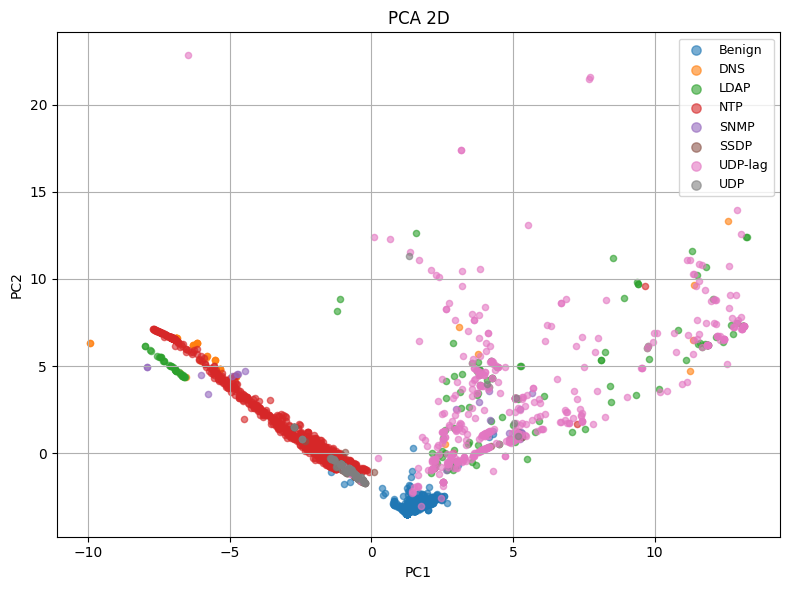

In [37]:
plt.figure(figsize=(8, 6))

for label, name in label_names.items():
    idx = y_train == label
    plt.scatter(
        x_train_pca[idx, 0],
        x_train_pca[idx, 1],
        label=name,
        alpha=0.6,
        s=20,
    )

plt.xlabel(f"PC1")
plt.ylabel(f"PC2")
plt.title("PCA 2D")
plt.legend(markerscale=1.5, fontsize=9)
plt.grid(True)

plt.tight_layout()
plt.show()

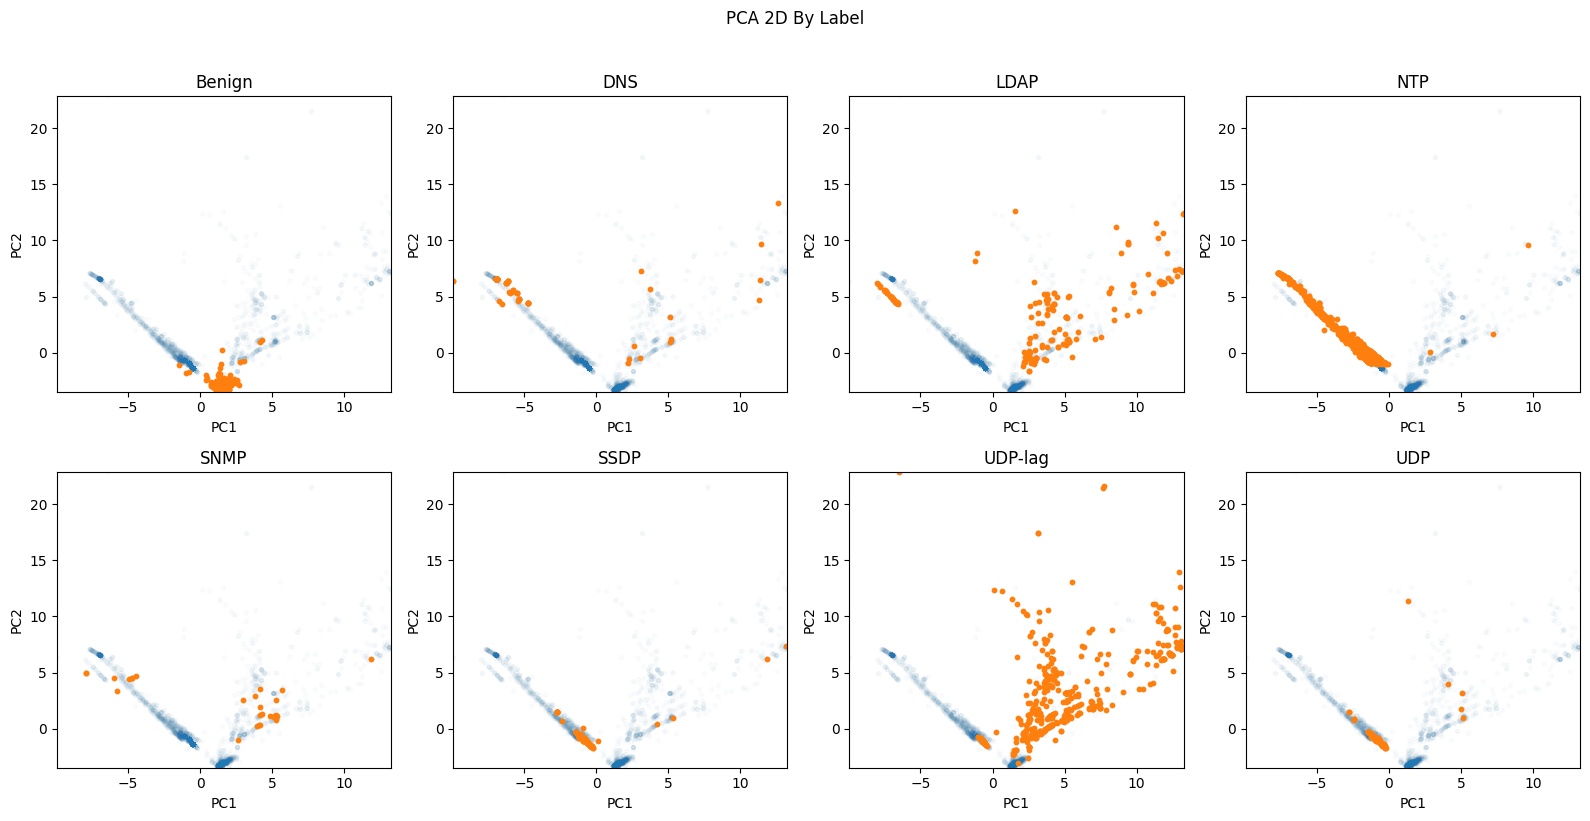

In [38]:
pc1 = x_train_pca[:, 0]
pc2 = x_train_pca[:, 1]
labels = y_train.to_numpy()

unique_labels = np.sort(np.unique(labels))

xlim = (pc1.min(), pc1.max())
ylim = (pc2.min(), pc2.max())

n = len(unique_labels)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows), squeeze=False)

for ax, lab in zip(axes.ravel(), unique_labels):
    name = label_names.get(lab, str(lab))
    mask = labels == lab

    ax.scatter(pc1, pc2, s=8, alpha=0.02)
    ax.scatter(pc1[mask], pc2[mask], s=10, alpha=1)

    ax.set_title(name)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

for ax in axes.ravel()[len(unique_labels):]:
    ax.axis("off")

fig.suptitle("PCA 2D By Label", y=1.02)
fig.tight_layout()
plt.show()


In [39]:
#
# 3D PCA
#

pca_3d = PCA(n_components=3, random_state=42)
x_train_pca_3d = pca_3d.fit_transform(x_train_scaled)

print("Explained variance:", pca_3d.explained_variance_ratio_)

feature_names = x_train.columns

loadings = pd.DataFrame(
    pca_3d.components_,
    columns=feature_names,
    index=[f"PC{i+1}" for i in range(pca_3d.n_components_)]
)

def top_features_per_pc(loadings, n=5):
    for pc in loadings.index:
        print(f"\n{pc}")
        print(
            loadings.loc[pc]
            .abs()
            .sort_values(ascending=False)
            .head(n)
        )

top_features_per_pc(loadings, n=5)

Explained variance: [0.29082109 0.22870673 0.12630011]

PC1
flow_iat_std       0.213978
fwd_iat_std        0.213978
fwd_iat_max        0.212906
flow_iat_max       0.212906
fwd_pkt_len_min    0.204853
Name: PC1, dtype: float64

PC2
totlen_fwd_pkts     0.230376
subflow_fwd_byts    0.230376
pkt_len_max         0.228778
fwd_pkt_len_max     0.228778
subflow_fwd_pkts    0.227788
Name: PC2, dtype: float64

PC3
pkt_len_max        0.286497
fwd_pkt_len_max    0.286497
pkt_len_var        0.266800
pkt_len_std        0.259918
fwd_pkt_len_std    0.259918
Name: PC3, dtype: float64


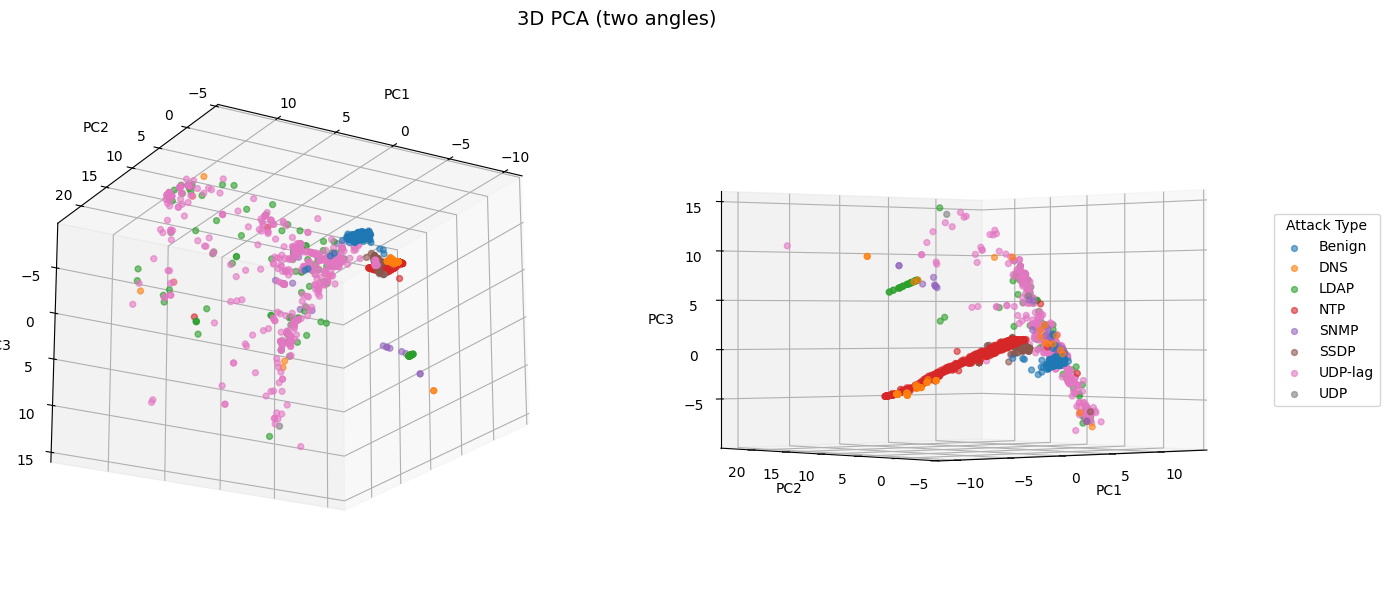

In [40]:
angles = [
    (160, 120),
    (0, 230),
]

fig = plt.figure(figsize=(14, 6))

for i, (elev, azim) in enumerate(angles, start=1):
    ax = fig.add_subplot(1, 2, i, projection="3d")

    for lab in sorted(np.unique(labels)):
        mask = labels == lab
        ax.scatter(
            x_train_pca_3d[mask, 0],
            x_train_pca_3d[mask, 1],
            x_train_pca_3d[mask, 2],
            s=18,
            alpha=0.6,
            label=label_names[lab],
        )

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")

    ax.view_init(elev=elev, azim=azim)

handles, labels_ = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels_,
    loc="center right",
    bbox_to_anchor=(1.05, 0.5),
    title="Attack Type",
)

fig.suptitle(
    "3D PCA (two angles)",
    fontsize=14,
    y=1.0,
)

plt.tight_layout()
plt.show()

In [41]:
#
# Train a very basic RF model to see baseline performance.
#
# Parameters here were simply picked based on a few tries to try and
# mitigate overfitting.
#

rf_base = RandomForestClassifier(
    n_estimators=500,
    max_depth=30,
    max_features="sqrt",
    min_samples_leaf=4,
    min_samples_split=8,
    random_state=42,
)

In [43]:
rf_base.fit(x_train, y_train)

y_pred = rf_base.predict(x_test)

print("Classification report:")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       0.88      0.91      0.89        23
           2       0.88      0.36      0.51        42
           3       0.98      0.98      0.98       194
           4       1.00      0.43      0.60         7
           5       0.51      0.57      0.54       188
           6       0.70      0.70      0.70       197
           7       0.51      0.53      0.52       190

    accuracy                           0.74      1041
   macro avg       0.81      0.68      0.72      1041
weighted avg       0.75      0.74      0.74      1041

Confusion matrix:
[[200   0   0   0   0   0   0   0]
 [  0  21   0   2   0   0   0   0]
 [  1   0  15   0   0   0  26   0]
 [  0   3   0 190   0   0   1   0]
 [  0   0   0   0   3   0   4   0]
 [  0   0   0   1   0 107  12  68]
 [  1   0   2   0   0  28 137  29]
 [  0   0   0   0   0  74  16 100]]


In [44]:
#
# Use "leave one out" permutation and RF to calculate feature importance scores
#

rf_importance = permutation_importance(
    rf_base,
    x_test,
    y_test,
    n_repeats=10,
    scoring="f1_macro",
    random_state=42,
)

In [47]:
rf_importance_scores = pd.Series(
    rf_importance.importances_mean,
    index=x_test.columns,
).sort_values(ascending=False)

print(rf_importance_scores)

selected_features = rf_importance_scores[rf_importance_scores > 0].index.tolist()
print(selected_features)

fwd_pkt_len_max      0.009331
subflow_fwd_pkts     0.006945
tot_fwd_pkts         0.006882
pkt_size_avg         0.006627
fwd_act_data_pkts    0.006512
                       ...   
fwd_iat_tot         -0.001978
fwd_iat_std         -0.002000
flow_iat_std        -0.002013
flow_iat_max        -0.002809
flow_pkts_s         -0.002942
Length: 76, dtype: float64
['fwd_pkt_len_max', 'subflow_fwd_pkts', 'tot_fwd_pkts', 'pkt_size_avg', 'fwd_act_data_pkts', 'totlen_fwd_pkts', 'pkt_len_std', 'pkt_len_var', 'fwd_pkt_len_mean', 'fwd_blk_rate_avg', 'fwd_header_len', 'fwd_pkts_b_avg', 'fwd_pkt_len_std', 'flow_duration', 'pkt_len_mean', 'pkt_len_max', 'fwd_pkt_len_min', 'fwd_byts_b_avg', 'subflow_fwd_byts', 'fwd_seg_size_avg', 'pkt_len_min', 'psh_flag_cnt', 'syn_flag_cnt', 'fwd_psh_flags', 'flow_byts_s', 'init_fwd_win_byts', 'ack_flag_cnt']


In [48]:
#
# Train a baseline Gradient Boosted Tree model (all features).
#
# Use grid search and 5-fold CV to find decent paramaters.
#

gbt = HistGradientBoostingClassifier(random_state=42, early_stopping=True)

param_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [3, 6, 10],
    "min_samples_leaf": [10, 30, 100],
    "max_iter": [300, 600],
}

grid = GridSearchCV(
    gbt,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
)

grid.fit(x_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

best_gbt = grid.best_estimator_
y_pred_gbt = best_gbt.predict(x_test)


print("Classification report:")
print(classification_report(y_test, y_pred_gbt))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_gbt))

print()

Best params: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 300, 'min_samples_leaf': 10}
Best CV score: 0.6324229869620268
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.88      0.96      0.92        23
           2       0.71      0.40      0.52        42
           3       0.99      0.98      0.99       194
           4       0.43      0.43      0.43         7
           5       0.48      0.54      0.51       188
           6       0.72      0.62      0.67       197
           7       0.49      0.55      0.52       190

    accuracy                           0.73      1041
   macro avg       0.71      0.69      0.69      1041
weighted avg       0.74      0.73      0.73      1041

Confusion matrix:
[[200   0   0   0   0   0   0   0]
 [  0  22   0   1   0   0   0   0]
 [  1   0  17   0   2   0  22   0]
 [  0   2   0 191   0   0   1   0]
 [  0   0   0   0   3   0   4   0]
 [  0

In [ ]:
#
# Now train GBT model on features selected after RF feature importance
# to see if there is improvement.
#
# Still use grid search and 5-fold CV.
#

x_train_selected = x_train[selected_features]
x_test_selected = x_test[selected_features]

grid = GridSearchCV(
    gbt,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
)

grid.fit(x_train_selected, y_train)
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best params: {'learning_rate': 0.03, 'max_depth': 3, 'max_iter': 300, 'min_samples_leaf': 100}
Best CV score: 0.6326635705962176


In [ ]:
best_gbt = grid.best_estimator_

y_pred_gbt = best_gbt.predict(x_test_selected)

print("Classification report:")
print(classification_report(y_test, y_pred_gbt))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_gbt))

print()

Classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       0.88      0.96      0.92        23
           2       0.93      0.33      0.49        42
           3       0.99      0.98      0.99       194
           4       1.00      0.43      0.60         7
           5       0.49      0.59      0.53       188
           6       0.78      0.64      0.71       197
           7       0.49      0.56      0.53       190

    accuracy                           0.74      1041
   macro avg       0.82      0.69      0.72      1041
weighted avg       0.77      0.74      0.74      1041

Confusion matrix:
[[200   0   0   0   0   0   0   0]
 [  0  22   0   1   0   0   0   0]
 [  1   0  14   0   0   0  27   0]
 [  0   3   0 190   0   0   1   0]
 [  0   0   0   0   3   0   4   0]
 [  0   0   0   0   0 110   0  78]
 [  1   0   1   0   0  36 127  32]
 [  0   0   0   0   0  79   4 107]]

Train accuracy: 0.74825846